# Explicarei aqui como profissionais que lidam com dados nos hospitais universitários federais administrados pela EBSERH podem se conectar à base do AGHU pelo R.

## Exemplo motivador
 Aqui vou mostrar como extrair da base de dados um relatório que o Pentaho no fornece.
>Primeiramente, deverá instalar o pacote RPostgreSQL para o R se conectar a base de dados do AGHU

In [6]:
require("RPostgreSQL")


Entre aspas, coloque a senha de acesso ao servidor.
O host é o endereço IP da máquina que hospeda o banco de dados do AGHU em seu hospital.

In [7]:
pw <- {
  ""
}
host<-""
drv <- dbDriver("PostgreSQL")
# creates a connection to the postgres database
# note that "con" will be used later in each connection to the database
con <- dbConnect(drv, dbname = "dbaghu",
                 host = host, port = 6544,
                 user = "ugen_integra", password = pw)
rm(pw) # removes the password

# Digitando a query em SQL.
A parte que esta entre aspas que carrega a variável query na verdade é a query em SQL que vai ser processada no servidor
no caso do AGHU o servidor é o Postgre.
## Funcionamento básico da consulta
Tudo que está após o select separado po vírgulas são as informações que necessitamos. Após o from são as tabelas que contém as informações que necessitamos. 
Após o ***FROM**, temos o nome das tabelas do AGHU que fornecem as informações. O nome destas tabelas deveriam ser iguais independente do hospital. Na query logo após o ***from*** temos bi.fato_internacao_indicador_unf_clc significa que no Schema bi ( schema é o nome de um conjunto de tabelas) queremos a tabela fato_internacao_indicador_unf_clc.
As palavras ***INNER***  e ***LEFT*** indicam o tipo de relacionamentos que queremos fazer durante a execução da consulta. De uma maneira simplista podemos dizer que INNER trata-se de uma relação bijetora entre as colunas das tabelas. O LEFT é uma relação em que todos os elemantos da tabela da esquerda aparecerão independente de haver cruzamento.

In [11]:
query<-"SELECT a.paciente_dia,a.saida+a.saida_movimentacao_unidade as saida,a.saida as saida_pura
        ,a.obito,b.mes,b.ano,b.descricao,c.descricao_neta,a.unidade_codigo
	FROM bi.fato_internacao_indicador_unf_clc as a left join bi.dim_unidade_funcional_v2 as c
	ON a.unidade_codigo=c.codigo
	INNER JOIN 	bi.dim_periodo as b 
    ON b.seq=a.periodo"
base<-dbGetQuery(con,query)
dbDisconnect(con)#disconecta do AGHU
tail(base)


,paciente_dia,saida,saida_pura,obito,mes,ano,descricao,descricao_neta,unidade_codigo
3772,123,13,13,0,9,2017,Setembro,PRONTO ATENDIMENTO PEDIATRICO 1Âº - L,14
3773,248,29,16,0,9,2017,Setembro,UNIDADE INTERMEDIÃRIA NEONATAL 2Âº - L,15
3774,58,5,4,2,9,2017,Setembro,CTI - PEDIATRICO 2Âº - L,20
3775,172,5,4,3,9,2017,Setembro,CTI - NEONATAL 2Âº - L,22
3776,41,12,6,0,9,2017,Setembro,NA,79
3777,12,9,3,0,9,2017,Setembro,NA,89


### Como podem ver na tabela acima a coluna descricao_neta possui caracteres ilegíveis.
Para resolver este problema cria-se uma função ***set_utf8*** que torna o conteúdo da tabela legível.

In [13]:
set_utf8 = function(x){
  # Declare UTF-8 encoding on all character strings:
  for (i in 1:ncol(x)){
    if (is.character(x[, i])) Encoding(x[, i]) <- 'UTF-8'
  }
  # Same on column names:
  for (name in colnames(x)){
    Encoding(name) <- 'UTF-8'
  }
  return(x)
}
base<-set_utf8(base)
print("tabela legível")
tail(base)

[1] "tabela legível"


,paciente_dia,saida,saida_pura,obito,mes,ano,descricao,descricao_neta,unidade_codigo
3772,123,13,13,0,9,2017,Setembro,PRONTO ATENDIMENTO PEDIATRICO 1º - L,14
3773,248,29,16,0,9,2017,Setembro,UNIDADE INTERMEDIÁRIA NEONATAL 2º - L,15
3774,58,5,4,2,9,2017,Setembro,CTI - PEDIATRICO 2º - L,20
3775,172,5,4,3,9,2017,Setembro,CTI - NEONATAL 2º - L,22
3776,41,12,6,0,9,2017,Setembro,NA,79
3777,12,9,3,0,9,2017,Setembro,NA,89


Ok, parabens você conseguiu executar uma consulta direto do servidor.
Mas esta tabela realmente é correta? 
Como verificar?
>Para verificar, vamos selecionar um período específico e uma unidade específica e comparar o resultado com o obtido em tela no AGHU.

In [16]:
subset(base,ano==2017 & unidade_codigo==20 & mes==9)

,paciente_dia,saida,saida_pura,obito,mes,ano,descricao,descricao_neta,unidade_codigo
3745,23,1,0,0,9,2017,Setembro,CTI - PEDIATRICO 2º - L,20
3767,35,0,0,0,9,2017,Setembro,CTI - PEDIATRICO 2º - L,20
3774,58,5,4,2,9,2017,Setembro,CTI - PEDIATRICO 2º - L,20


Verifique:
>116 (23+35+58) pacientes dia;

>2 óbitos;

>4 saídas.

Warning message:
"package 'IRdisplay' was built under R version 3.3.3"

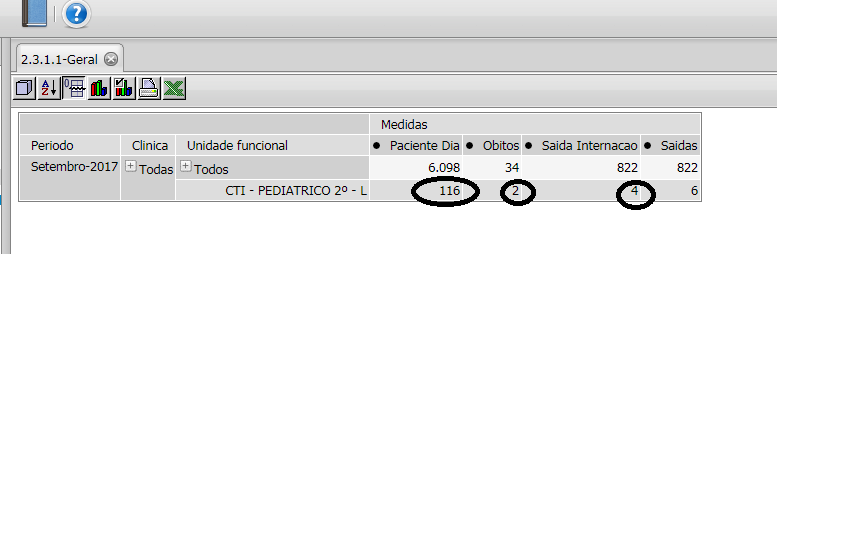

In [19]:
library("IRdisplay")
display_png(file="C:\\Users\\dalton.pinheiro\\Documents\\Pentaho.png")

Veja aonde localizar o Schema no software pgAdmin.
Geralmente o Schema mais importante é o agh este conjunto possui mais de 3000 tabelas.

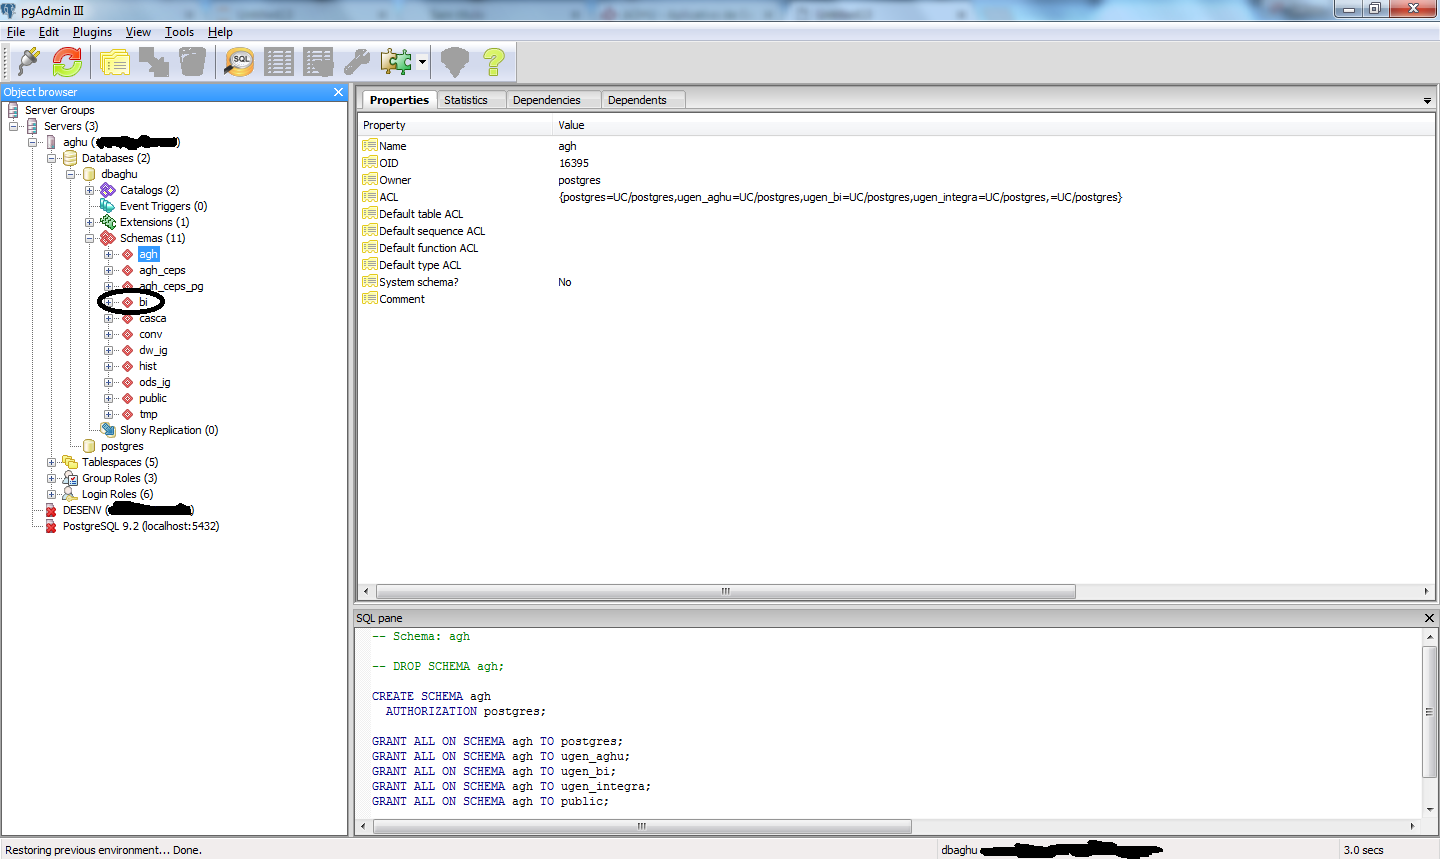

In [22]:
display_png(file="C:\\Users\\dalton.pinheiro\\Documents\\Base_dados.png")

## Consideração Final
O módulo Pentaho do AGHU realiza consultas as bases do Schema bi.
Estas tabelas contidas neste Schema são o que chamamos de datawarehouse.
Elas são carregadas todo final de mês uma única vez, isto é feito para não criar contradição, ou seja, se realizar esta consulta em uma base transacional (fora do Schema bi) o resultado muda a cada momento.
Se você deseja saber quantos pacientes internados neste momento, seria mais adequado consultar uma base transacional.